In [1]:
import sys

PWD = '../../..'
sys.path.append(PWD)

from joblib import Parallel, delayed
import time

WAV_FILE_PATH = PWD + '/data/input/waveforms_r354332.root'
DATASET_PATH = PWD + '/data/converted_input/dataset_r354332.pkl'

# IMAGES_DIR = '../../data/images/convert_input/'

import uproot
import pickle

import numpy as np
from matplotlib import pyplot as plt

from src.cfd import CFD
from src.waveform_data import EventData, WaveformData
from src.utils import save_plt

# Load file

In [2]:
N_JOBS = 16

In [3]:
SECTOR = 'sector 56'
STATION = 'station 220cyl'
RP = 'cyl_hr'

data_dir = f'wav/CTPPS/TimingDiamond/{SECTOR}/{STATION}/{RP}'

In [4]:
file_raw = uproot.open(WAV_FILE_PATH)

len(file_raw[data_dir].keys(recursive=False))

59988

In [5]:
sorted_events = sorted(file_raw[data_dir].keys(recursive=False), key=lambda x: int(x[6:-2]))
sorted_events[:10]

['event 200;1',
 'event 500;1',
 'event 700;1',
 'event 1113;1',
 'event 1510;1',
 'event 1705;1',
 'event 2400;1',
 'event 2800;1',
 'event 3068;1',
 'event 3150;1']

In [6]:
# file_raw[data_dir]['event 3375;1'].keys(recursive=False)

In [7]:
# file_raw[data_dir]['event 3375;1']['plane 1;1']['channel 11;1'].keys(recursive=False)

# Transform the dataset

In [8]:
def find_slices(length, n):
    interval = length // n
    slices = [i * interval for i in range(n)] + [length]
    return slices

def transform_event_collection(file_raw, data_dir, events):
    dataset = []
    for event in events:
        event_int = int(event[6:-2])
        event_data = file_raw[data_dir][event]
        dataset.append((event_int, EventData.from_event_data(event_data)))
    return dataset

start = time.time()
slices = find_slices(len(sorted_events), N_JOBS)
dataset = Parallel(n_jobs=N_JOBS)(delayed(transform_event_collection)(file_raw, data_dir, sorted_events[slices[i]:slices[i+1]]) for i in range(len(slices) - 1))
dataset = dict(sum(dataset, []))
end = time.time()
print(f'Elapsed time: {end - start:0.2f} s')

# store the dataset
with open(DATASET_PATH, 'wb') as file:
    pickle.dump(dataset, file)

Elapsed time: 38.66 s


In [9]:
file_raw.close()

In [10]:
# load the dataset
with open(DATASET_PATH, 'rb') as file:
    original_dataset = pickle.load(file)

In [11]:
# print(original_dataset[3375])

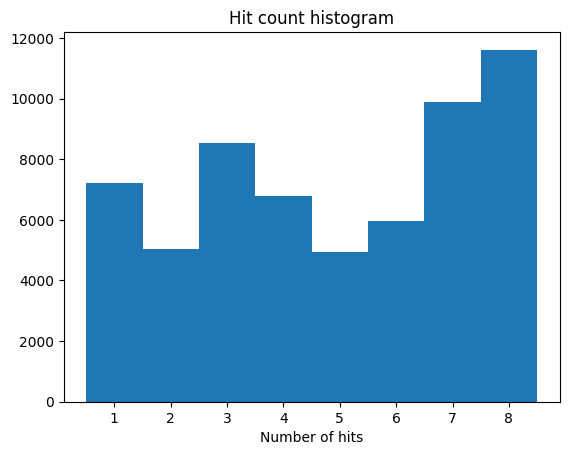

In [12]:
def plot_hit_count_histogram(dataset, title='Hit count histogram'):
    hit_count_histogram = [event_data.get_hit_count() for event_data in dataset.values()]

    plt.hist(hit_count_histogram, bins=range(1, 8 + 2), align='left')
    plt.title(title)
    plt.xlabel('Number of hits')
    
plot_hit_count_histogram(original_dataset)
plt.show()

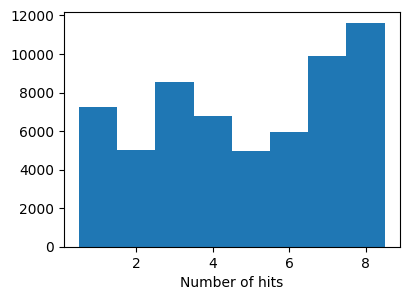

In [13]:
def plot_hit_count_histogram(dataset, title='Hit count histogram'):
    hit_count_histogram = [event_data.get_hit_count() for event_data in dataset.values()]

    plt.hist(hit_count_histogram, bins=range(1, 8 + 2), align='left')
    plt.xlabel('Number of hits')

plt.figure(figsize=(4.2, 3.1))
plot_hit_count_histogram(original_dataset)
plt.tight_layout()
# save_plt(IMAGES_DIR + f"hit_count.pdf")
plt.show()

# Examples

In [14]:
events_to_view = []
for event, event_data in original_dataset.items():
    if event_data.get_plane_count() == 4 and event_data.get_hit_count() == 4:
        events_to_view.append(event)
    if len(events_to_view) == 10:
        break
        
events_to_view

[2800, 3068, 6558, 11178, 19553, 33212, 38770, 54790, 59835, 61710]

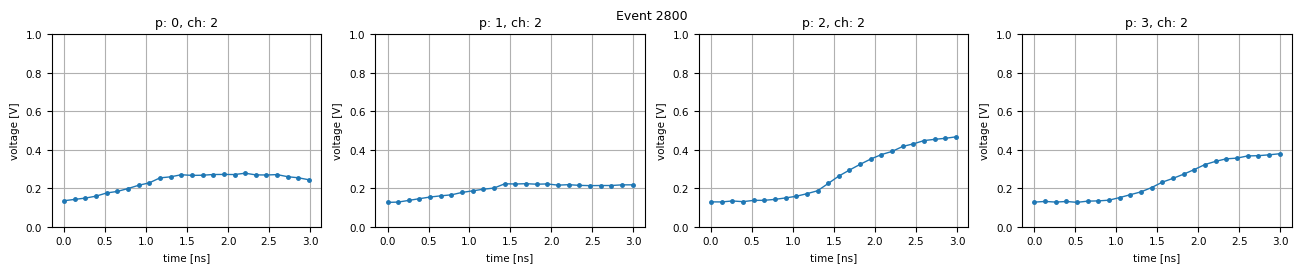

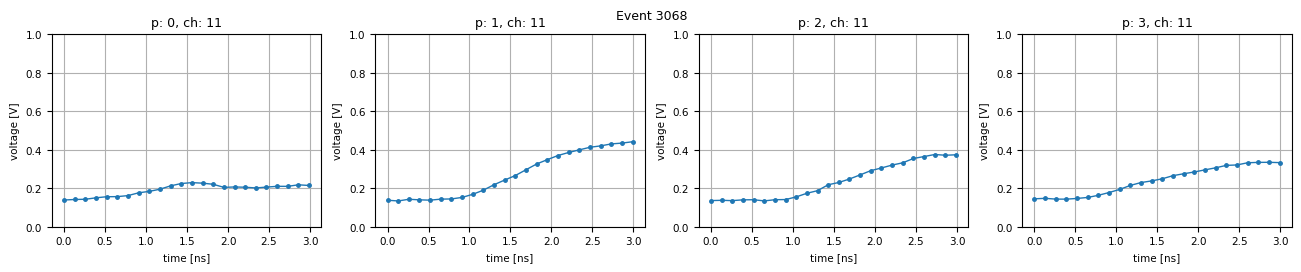

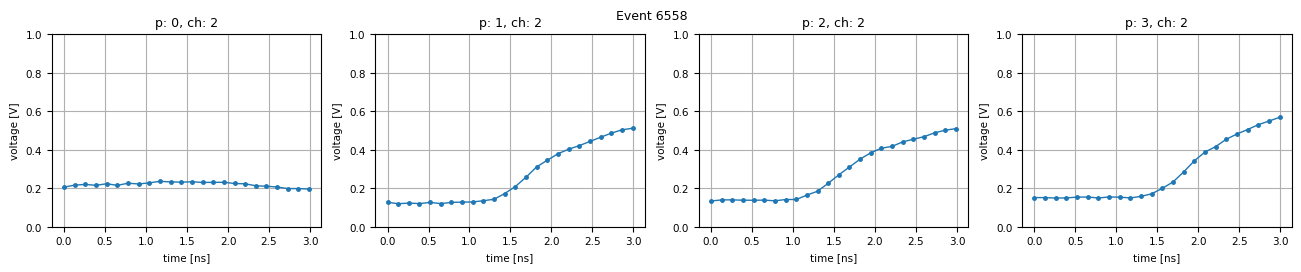

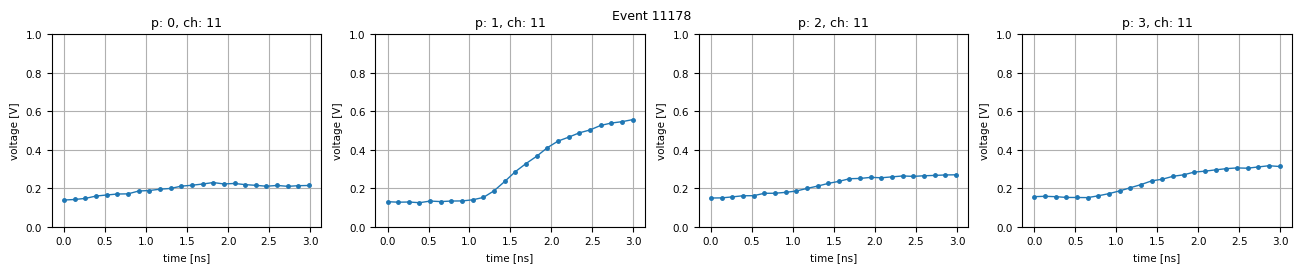

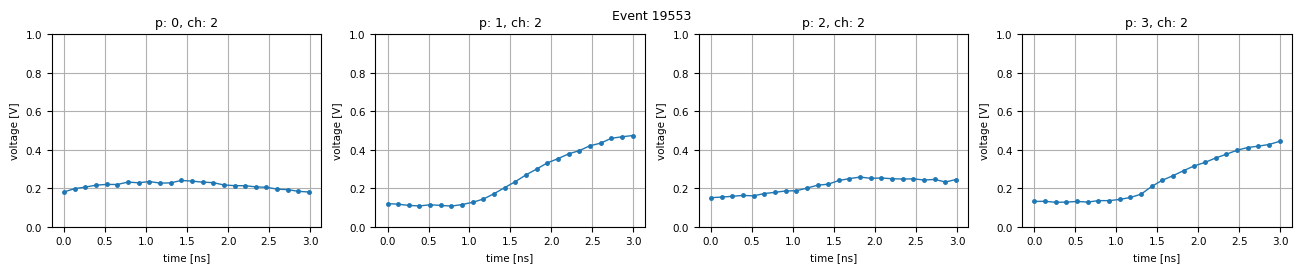

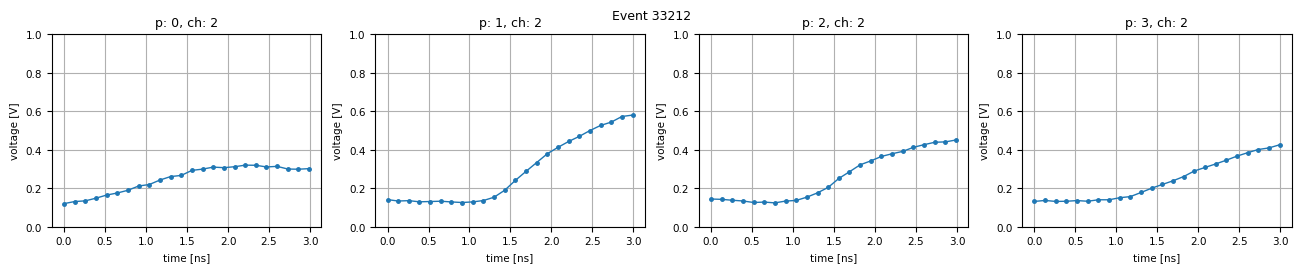

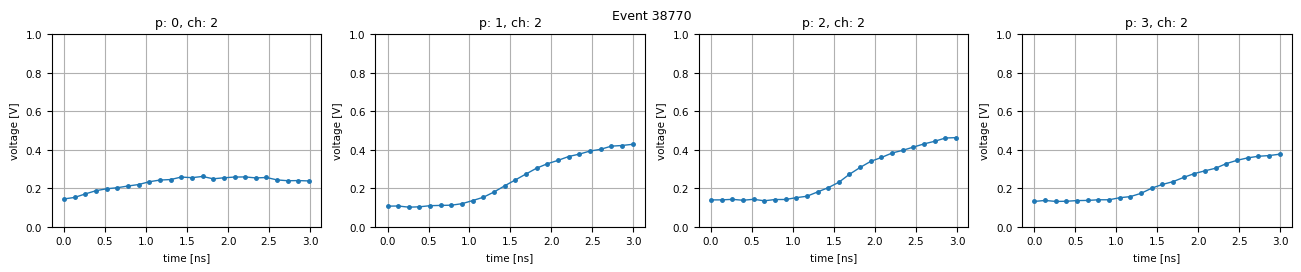

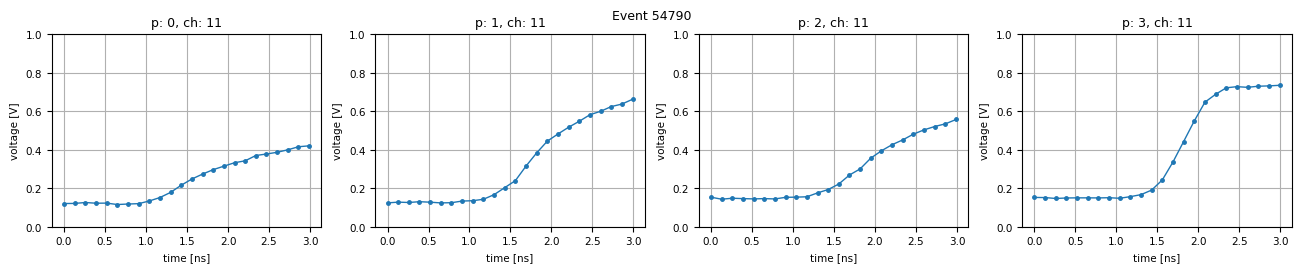

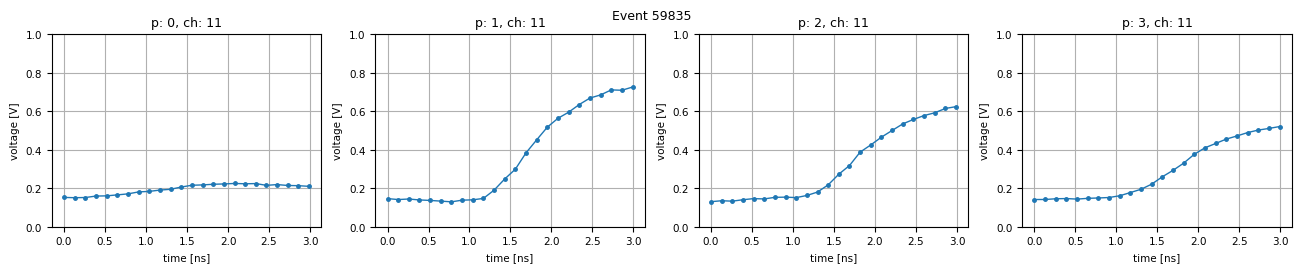

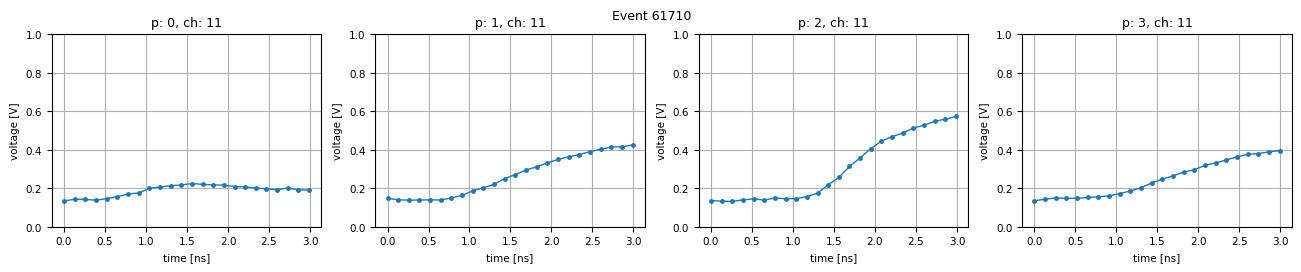

In [15]:
for event in events_to_view:
    plt.figure(figsize=(16, 2.5))
    plt.rc('font', size=7.5)
    
    for i, (plane, channel, wav_data) in enumerate(original_dataset[event].get_all_waveforms()):
        plt.subplot(1, 4, i + 1)
        plt.plot(wav_data.series[0], wav_data.series[1], marker='.', linewidth=1, markersize=5)
        plt.ylim(0, 1)
        plt.title(f'p: {plane}, ch: {channel}')
        plt.xlabel('time [ns]')
        plt.ylabel('voltage [V]')
        plt.grid()
    
    # plt.tight_layout()
    # plt.subplots_adjust(top=0.85)
    plt.suptitle(f'Event {event}')
    
    plt.show()

In [16]:
# events_to_save = [19792, 112450]
# for i_event, event in enumerate(events_to_save):
#     plt.figure(figsize=(15, 3))
#     plt.rc('font', size=14)
#
#     for i, (plane, channel, wav_data) in enumerate(original_dataset[event].get_all_waveforms()):
#         plt.subplot(1, 4, i + 1)
#         plt.plot(wav_data.series[0], wav_data.series[1], marker='.', linewidth=1, markersize=5)
#         plt.ylim(0, 1)
#         plt.title(f'plane: {plane}, channel: {channel}')
#         plt.xlabel('time [ns]')
#         plt.ylabel('voltage [V]')
#         plt.grid()
#
#     plt.tight_layout()
#     plt.subplots_adjust(top=0.85)
#     # plt.suptitle(f'Event {event}')
#
#     # save_plt(IMAGES_DIR + f"example_signal_{i_event}.pdf")
#     plt.show()